In [2]:
#-*- coding: utf-8 -*-
import pickle
import os
import gc

def dec_to_hex(num):                                                                                                                           
    """ num : string                                                                                                                           
    range: 0x00-0x00ff                                                                                                                         
    """                                                                                                                                        
    t = int(num)                                                                                                                               
    assert 0x00ff, "out of range: " + str(t)                                                                                                   
    r = hex(t)                                                                                                                                 
    result = None                                                                                                                              
    if t > 0x000f:                                                                                                                             
        result = '0x00' +r[-2:]                                                                                                                
    else:                                                                                                                                      
        result = '0x000' +r[-1]                                                                                                                
    return result                                                                                                                              
                                                                                                                                               
def get_task_id(task_path):                                                                                                                    
    global task_line                                                                                                                           
    with open(task_path) as f:                                                                                                                 
        line = f.readlines()                                                                                                                   
                                                                                                                                               
    task_line = filter(lambda e: '__runTask()' in e , line)                                                                                    
    tasks_name = list()                                                                                                                        
                                                                                                                                               
    for e in task_line:                                                                                                                        
        if '/*' not in e and e not in tasks_name:                                                                                              
            tasks_name.append(e.strip())                                                                                                       
        elif '/*' in e:                                                                                                                        
            tasks_name.append(e[e.index('*/')+2:].strip())                                                                                     
                                                                                                                                               
    temp_tasks_name = list(map(lambda x: x[:-12], tasks_name))                                                                                 
    temp_tasks_id = list() #用于存放含有对任务名定义的行                                                                                       
    temp_list = list() #存放分割后的 temp_tasks_id                                                                                             
    temp_task_define = list() ##用于仅仅存放含有对任务名定义的行                                                                               
    task_id_temp = list()                                                                                                                      
    task_id = list()                                                                                                                           
                                                                                                                                               
    for e in temp_tasks_name:                                                                                                                  
        for i in line:                                                                                                                         
            if e in i and ' = ' in i and 'U' in i:                                                                                             
                temp_tasks_id.append(i.strip())                                                                                                
                                                                                                                                               
    for e in temp_tasks_id:                                                                                                                    
        temp_list.append(e.split(' '))                                                                                                         
    #map(lambda e: temp_list.append(e.split(' ')), temp_tasks_id) # do not work in python3                                                     
    for e in temp_tasks_name:                                                                                                                  
        for i in temp_list:                                                                                                                    
            if e == i[0] and i not in temp_task_define:                                                                                        
                temp_task_define.append(i)                                                                                                     
                                                                                                                                               
    for e in temp_task_define: task_id_temp.append((e[0], e[-1][:-1]))                                                                         
    #map(lambda e: task_id_temp.append((e[0], e[-1][:-1])), temp_task_define)    # do not work in python3                                      
                                                                                                                                               
    for e in task_id_temp: task_id.append((e[0], dec_to_hex(e[1])))                                                                            
    #map(lambda e: task_id.append((e[0], dec_to_hex(e[1]))), task_id_temp)# do not work in python3   
                                                                                                                                               
    return len(task_id_temp), task_id, task_id_temp # 分别以十六进制和十进制表示  

def wc(fn):
    """ the same as `wc -l fn` on linux 
    """
    with open(fn,'rb') as f:
        count = 0
        last_data = '\n'
        while True:
            data = f.read(0x400000)
            if not data:
                break
            count += data.count(b'\n')
            last_data = data
        if last_data[-1:] != b'\n':
            count += 1 # Remove this if a wc-like count is needed
    return count


def containlogfile(folder):
    ''' Does the folder contain log file?
    Args:
        folder: str
    '''
    
    for e in os.listdir(folder):
        if '.pkl' in e:
            return True        
    return False

data_path = '../TinyOS-Benchmark/preprocessed-dataset/'
paths_data = {}
paths = list(os.walk(data_path))
for i in range(len(paths)):
    #if i > 18: break
    print('\n{:2}/{:2}: {}'.format(i, len(paths)-1, paths[i][0]))
    if containlogfile(paths[i][0]) and paths[i][0] not in paths_data:
        app_c = paths[i][0].replace('preprocessed-dataset', 'app.c') + '/app.c'
        if os.path.isfile(app_c):
            task_num = get_task_id(app_c)[0]
            if task_num < 10: # 少于10个任务的就不统计了
                print(' :)') # 为了换行
                continue                
            print(' lines: {},\ttasks num: {}'.format(wc(app_c), task_num), end='')
        else:
            print(' lines: no app.c')
            continue
            
        paths_data[paths[i][0]] = []
        for e2 in paths[i][2]:
            fn = os.path.join(paths[i][0], e2)
            with open(fn, 'rb') as f:
                paths_data[paths[i][0]] += pickle.load(f)
        print(' log items: {}\t'.format(len(paths_data[paths[i][0]])), end='')

    print(' :)')


def most_tasks(ls, num=5):
    ''' shoot tasks make up the majority in the logs
    Args:
        ls: list, logs look [(timestamp, taskid) ...]
        num: int, the top of task
    Retval:
        ([(taskid, number, precent) ... num], allprecent, num)
        allprecent is the sum of each prcent in the first item precents  
        num is the number of tasks, len(ls) yet.
    '''
    count = {}
    for e in ls:
        if e[1] in count:
            count[e[1]] += 1
        else:
            count[e[1]] = 1

    count = list(map(lambda k: (k, count[k]), count.keys()))
    count = sorted(count, key=lambda e: e[1], reverse=True)
    #count = list(map(lambda e: (e[0], e[1],  # using round to calculate the precent of tasks
    #                 round(float(e[1]) / len(ls), 2)), count))
    # no round() function
    count = list(map(lambda e: (e[0], e[1], 
                    float(e[1]) / len(ls)), count))    
    return count[:num], sum(map(lambda e: e[2], count[:num])), len(ls)



 0/49: ../TinyOS-Benchmark/preprocessed-dataset/
 :)

 1/49: ../TinyOS-Benchmark/preprocessed-dataset/RadioSenseToLeds
 lines: 27174,	tasks num: 20 log items: 750587	 :)

 2/49: ../TinyOS-Benchmark/preprocessed-dataset/TCPEcho
 lines: 33683,	tasks num: 23 log items: 371940	 :)

 3/49: ../TinyOS-Benchmark/preprocessed-dataset/MultihopOscilloscope
 lines: 42021,	tasks num: 40 log items: 384617	 :)

 4/49: ../TinyOS-Benchmark/preprocessed-dataset/tests
 :)

 5/49: ../TinyOS-Benchmark/preprocessed-dataset/tests/TestLpl
 lines: 22306,	tasks num: 19 log items: 286576	 :)

 6/49: ../TinyOS-Benchmark/preprocessed-dataset/tests/RadioStress
 lines: 21176,	tasks num: 15 log items: 402764	 :)

 7/49: ../TinyOS-Benchmark/preprocessed-dataset/tests/TestLed
 :)

 8/49: ../TinyOS-Benchmark/preprocessed-dataset/tests/TestLed/MultiLedSingle
 :)

 9/49: ../TinyOS-Benchmark/preprocessed-dataset/tests/TestLed/BlinkLed
 :)

10/49: ../TinyOS-Benchmark/preprocessed-dataset/tests/TestLed/MultiLed
 :)

11/49: 

In [3]:
###################### 2d ######################################
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

plt.figure(0)
top_task_num = 5
y = []
idx = 1 #
for k, v in paths_data.items():
    retval = most_tasks(v, top_task_num)
    for e in map(lambda e: e[2], retval[0]):
        plt.plot([idx], [e], marker='o', color='r')
    idx += 1
    y.append(sum(map(lambda e: e[2], retval[0])))
plt.ylim(0, 1)
plt.plot(list(range(1, len(y) + 1)), y, marker='o', linestyle=' ')

plt.savefig('feature-by-frequency-2d.png')
plt.show()  
plt.close(0)
############ end of 2d ###########

<Figure size 640x480 with 1 Axes>

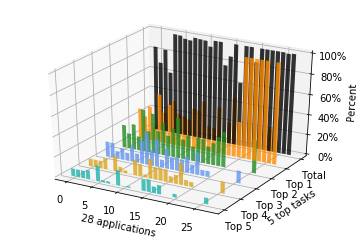

In [4]:

###################### 3d ######################################
colors = ['darkorange', 'forestgreen', 'cornflowerblue', 'goldenrod', 'lightseagreen', 'blueviolet', 'red',
         'y', 'teal', 'fuchsia', 'orangered', 'lawngreen', 'hotpink']

prob = [[] for i in range(top_task_num)]
for k, v in paths_data.items():
    retval = most_tasks(v, top_task_num)
    #temp = list(map(lambda e: e[2], retval[0]))
    for i in range(top_task_num):
        if i >= len(retval[0]):
            prob[i].append(0.0)
        else:
            prob[i].append(retval[0][i][2])
plus_prob = []    

# Add up all the values.
for i in range(len(prob[0])):
    plus_prob.append(sum(map(lambda e: e[i], prob)))
prob.insert(0, plus_prob)

fig = plt.figure(1)
ax = fig.gca(projection='3d')
idx = 0
for c, z in zip(['k'] + [colors[i] for i in range(top_task_num)], reversed([i * 10 for i in range(top_task_num + 1)])):
    xs = np.arange(len(prob[0]))
    ys = prob[idx]
    idx += 1
    # You can provide either a single color or an array. To demonstrate this,
    # the first bar of each set will be colored cyan.
    cs = [c] * len(xs)
    ax.bar(xs, ys, zs=z, zdir='y', color=cs, alpha=0.8)
    
#ax.set_xlim(0, 1)
#ax.set_ylim(0, 1)
ax.set_zlim(0, 1)
ax.set_yticklabels(['Top {}'.format(top_task_num-i) for i in range(top_task_num)] + ['Total'])
ax.set_zticklabels(['{}%'.format(i*20) for i in range(6)])
ax.set_xlabel('{} applications'.format(len(prob[0])))
ax.set_ylabel('{} top tasks'.format(top_task_num))
ax.set_zlabel('Percent')
plt.savefig('feature-by-frequency-3d.png')
plt.show()
plt.close(1)
############ end of 3d ###########